# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\tag{1}
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\tag{2}
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otoczenia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\tag{3}
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3. Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

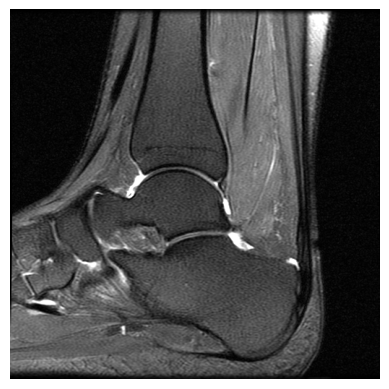

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy import signal
import math
import os

if not os.path.exists("MR_data.mat") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate

mat = loadmat('MR_data.mat')

Input_1 = mat['I_noisy1']
Input_2 = mat['I_noisy2']
Input_3 = mat['I_noisy3']
Input_4 = mat['I_noisy4']
Input_0 = mat['I_noisefree']

plt.imshow(Input_4, 'gray')
plt.axis('off')
plt.show()

In [2]:
def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g / g.sum()


def fgaussian2(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g 

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

In [3]:
input_1_gauss = signal.convolve2d(Input_1, fgaussian(5, 0.7), mode='same')

In [4]:
def pixel_out(window, filter, var):
    A, B = window.shape
    pixel = 0
    x = [A // 2, B // 2]
    for i in range(A):
        for j in range(B):
            AB=[i, j]
            y = np.sqrt(((x[0]-AB[0])**2)+((x[1]-AB[1])**2))
            gauss = np.exp(-(y**2)/(2*(var**2)))
            pixel = pixel + gauss * window[i, j]
    pixel=pixel/filter.sum()
    return pixel

In [5]:
def convol(img, window, var):
    filter = fgaussian2(5, var)
    IConv = img.copy()
    X, Y = IConv.shape
    half = window // 2
    for i in range(half, X - half):
        for j in range(half, Y - half):
            new_window = IConv[i - half : i + 1 + half, j - half : j + 1 + half]
            new_pixel = pixel_out(new_window, filter, var)
            IConv[i, j] = new_pixel
    return IConv

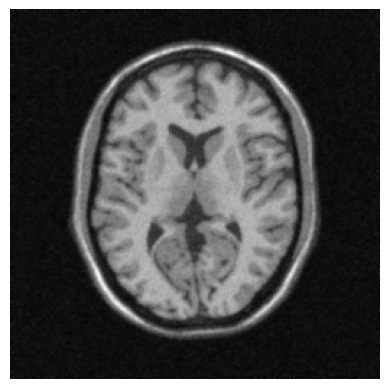

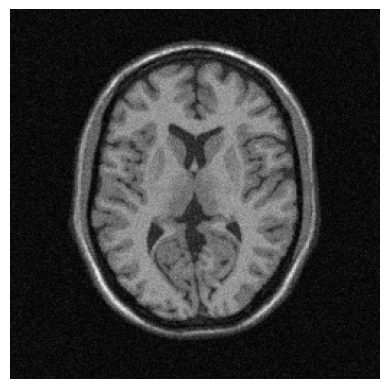

In [27]:
new_img = convol(Input_1, 5, 0.7)
plt.imshow(new_img, 'gray')
plt.axis('off')
plt.show()
plt.imshow(Input_1, 'gray')
plt.axis('off')
plt.show()

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gaussowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

In [16]:
def pixel_out2(window, filter, var, delta):
    A, B = window.shape
    norm = 0
    pixel = 0
    x = [A // 2, B // 2]
    for i in range(A):
        for j in range(B):
            AB = [i, j]
            y = np.sqrt(((x[0]-AB[0])**2)+((x[1]-AB[1])**2))
            gauss = np.exp(-(y**2)/(2*(var**2)))
            diff = np.abs(window[A // 2, B // 2] - window[i, j])
            gauss_diff = np.exp(-(diff ** 2) / (2 * (delta ** 2)))
            pixel = pixel + gauss * gauss_diff * window[i, j]
            norm += gauss * gauss_diff
    pixel = pixel / norm
    return pixel

In [19]:
def bilateral(img, window, var , delta):
    filter = fgaussian2(window, var)
    IConv = img.copy()
    (X, Y) = IConv.shape
    half = window // 2
    for i in range(half, X - half):
        for j in range(half, Y - half):
            new_window = IConv[i - half : i+ 1 + half, j - half : j+ 1 + half]
            new_pixel = pixel_out2(new_window, filter, var, delta)
            IConv[i,j] = new_pixel
    return IConv

(-0.5, 255.5, 255.5, -0.5)

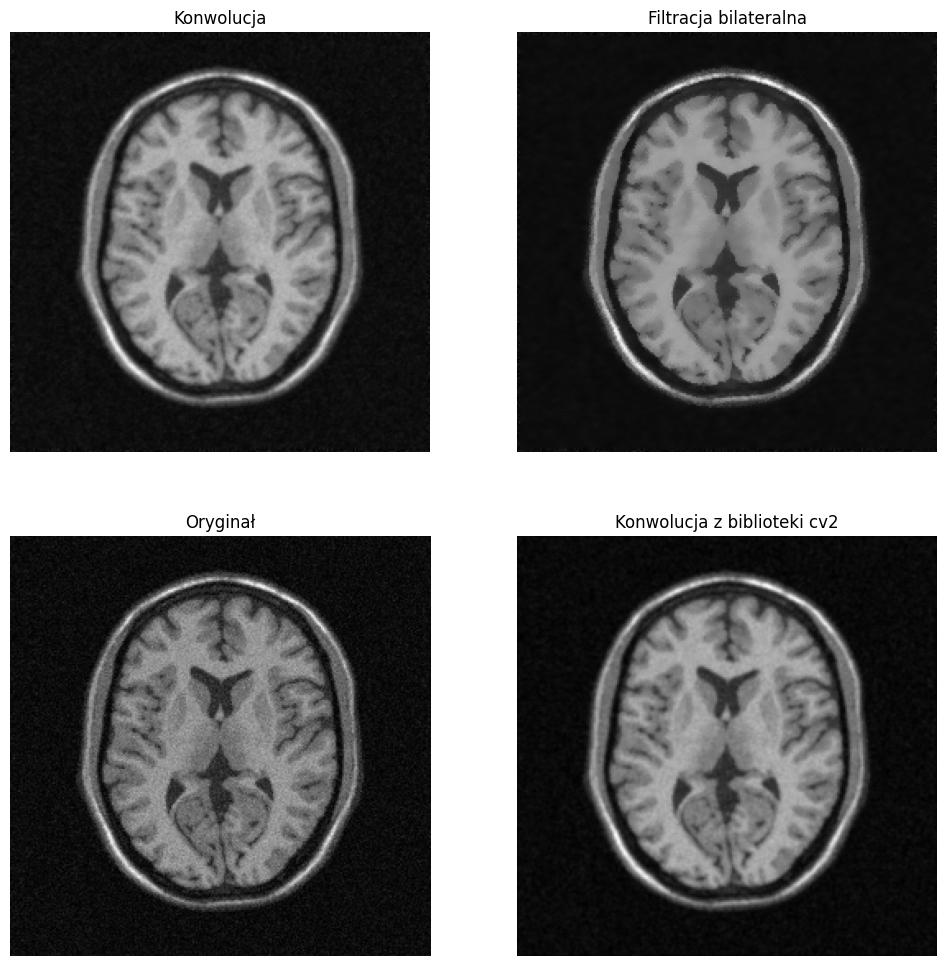

In [21]:
conv = convol(Input_1, 5, 0.7)
bil = bilateral(Input_1, 5, 5, 20)
Input_1_gauss = signal.convolve2d(Input_1, fgaussian(5, 0.7), mode='same')

f, ax1 = plt.subplots(2, 2, figsize=(12, 12))
ax1[0, 0].imshow(conv, 'gray')
ax1[0, 0].set_title("Konwolucja")
ax1[0, 0].axis('off')
ax1[0, 1].imshow(bil, 'gray')
ax1[0, 1].set_title("Filtracja bilateralna")
ax1[0, 1].axis('off')
ax1[1, 0].imshow(Input_1, 'gray')
ax1[1, 0].set_title("Oryginał")
ax1[1, 0].axis('off')
ax1[1, 1].imshow(Input_1_gauss, 'gray')
ax1[1, 1].set_title("Konwolucja z biblioteki cv2")
ax1[1, 1].axis('off')

(-0.5, 255.5, 255.5, -0.5)

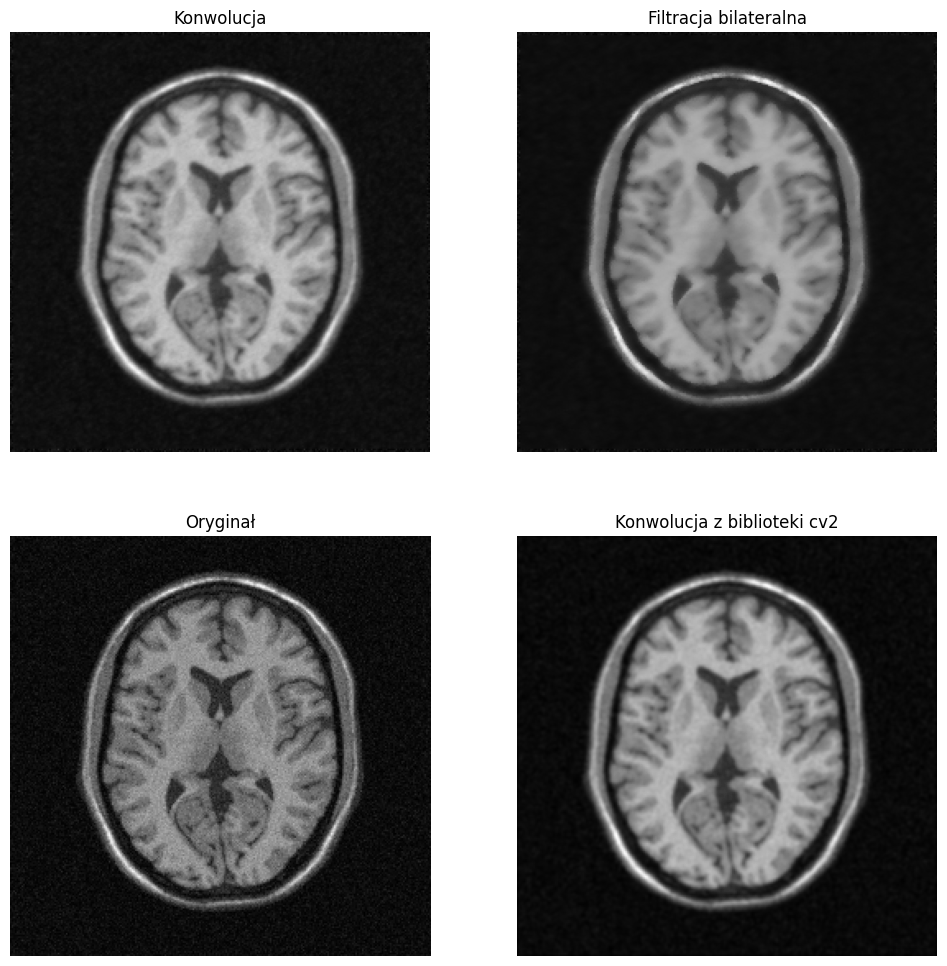

In [22]:
conv = convol(Input_1, 5, 0.9)
bil = bilateral(Input_1, 5, 3, 45)
Input_1_gauss = signal.convolve2d(Input_1, fgaussian(5, 0.9), mode='same')

f, ax1 = plt.subplots(2, 2, figsize=(12, 12))
ax1[0, 0].imshow(conv, 'gray')
ax1[0, 0].set_title("Konwolucja")
ax1[0, 0].axis('off')
ax1[0, 1].imshow(bil, 'gray')
ax1[0, 1].set_title("Filtracja bilateralna")
ax1[0, 1].axis('off')
ax1[1, 0].imshow(Input_1, 'gray')
ax1[1, 0].set_title("Oryginał")
ax1[1, 0].axis('off')
ax1[1, 1].imshow(Input_1_gauss, 'gray')
ax1[1, 1].set_title("Konwolucja z biblioteki cv2")
ax1[1, 1].axis('off')

/tmp/ipykernel_8020/778291453.py:11: RuntimeWarning: overflow encountered in ubyte_scalars
  diff = np.abs(window[A // 2, B // 2] - window[i, j])


(-0.5, 559.5, 559.5, -0.5)

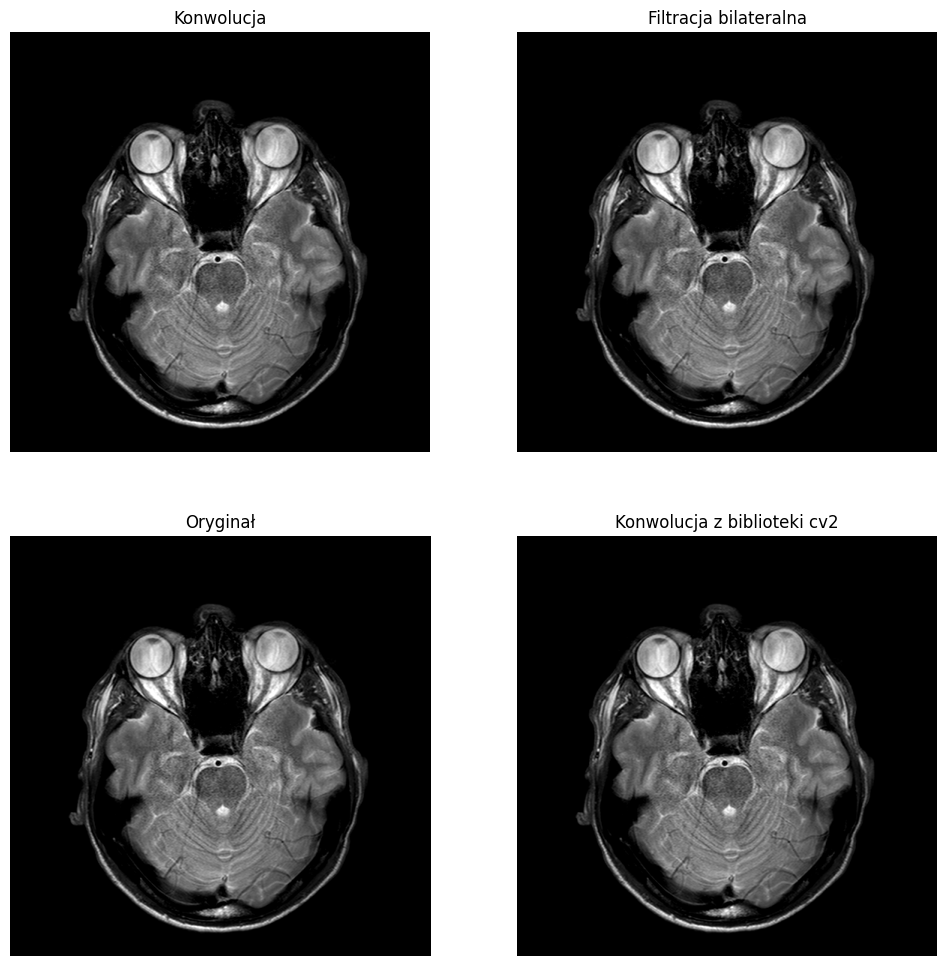

In [24]:
conv = convol(Input_3, 5, 0.1)
bil = bilateral(Input_3, 5, 0.5, 5)
Input_1_gauss = signal.convolve2d(Input_3, fgaussian(5, 0.1), mode='same')

f, ax1 = plt.subplots(2, 2, figsize=(12, 12))
ax1[0, 0].imshow(conv, 'gray')
ax1[0, 0].set_title("Konwolucja")
ax1[0, 0].axis('off')
ax1[0, 1].imshow(bil, 'gray')
ax1[0, 1].set_title("Filtracja bilateralna")
ax1[0, 1].axis('off')
ax1[1, 0].imshow(Input_3, 'gray')
ax1[1, 0].set_title("Oryginał")
ax1[1, 0].axis('off')
ax1[1, 1].imshow(Input_1_gauss, 'gray')
ax1[1, 1].set_title("Konwolucja z biblioteki cv2")
ax1[1, 1].axis('off')

/tmp/ipykernel_8020/778291453.py:11: RuntimeWarning: overflow encountered in ubyte_scalars
  diff = np.abs(window[A // 2, B // 2] - window[i, j])


(-0.5, 511.5, 511.5, -0.5)

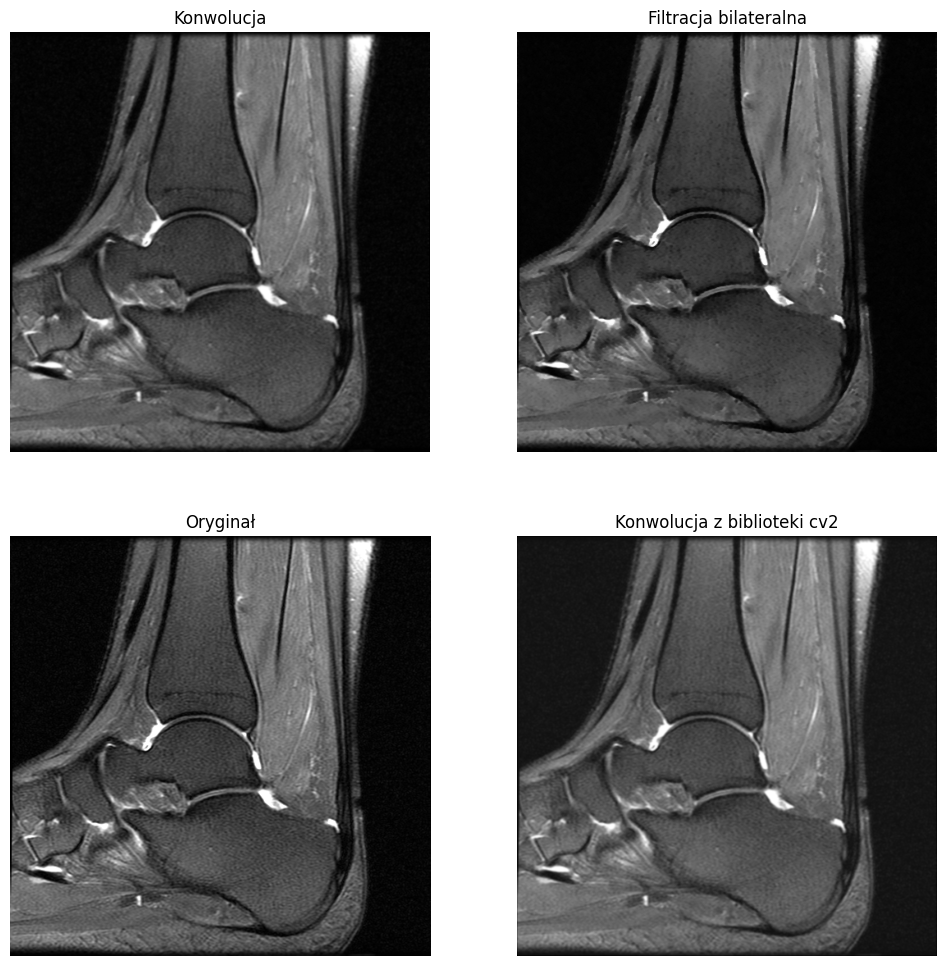

In [25]:
conv = convol(Input_4, 5, 0.7)
bil = bilateral(Input_4, 5, 5, 20)
Input_1_gauss = signal.convolve2d(Input_4, fgaussian(5, 0.7), mode='same')

f, ax1 = plt.subplots(2, 2, figsize=(12, 12))
ax1[0, 0].imshow(conv, 'gray')
ax1[0, 0].set_title("Konwolucja")
ax1[0, 0].axis('off')
ax1[0, 1].imshow(bil, 'gray')
ax1[0, 1].set_title("Filtracja bilateralna")
ax1[0, 1].axis('off')
ax1[1, 0].imshow(Input_4, 'gray')
ax1[1, 0].set_title("Oryginał")
ax1[1, 0].axis('off')
ax1[1, 1].imshow(Input_1_gauss, 'gray')
ax1[1, 1].set_title("Konwolucja z biblioteki cv2")
ax1[1, 1].axis('off')